In [1]:
# Get pandas and postgres to work together
import psycopg2 as pg
import pandas as pd

# We are also going to do some basic viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
import pickle
import numpy as np

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
with open('data/df_full.pickle', 'rb') as f:
    df = pickle.load(f)

## Split data into train and test

In [4]:
len(df)

11826

In [5]:
import sklearn
from sklearn.model_selection import train_test_split

In [6]:
df_train, df_test = train_test_split(df, test_size=.20, random_state=42)

In [7]:
X_train = df_train.iloc[:,4:9]
y_train = df_train['category']
X_test = df_test.iloc[:,4:9]
y_test = df_test['category']

## Oversampling

In [8]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
Obese = np.sum(y_train == 'Obese')
Average = np.sum(y_train == 'Average')
Fitness = np.sum(y_train == 'Fitness')
Athlete = np.sum(y_train == 'Athlete')
ratio = {'Obese': Obese, 'Average': Average*2, 'Fitness': Fitness*5, 'Athlete': Athlete*10} 


In [9]:
#initialize random sampler for later use
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = 'auto', random_state=42) 
    
# X_tr_rs, y_tr_rs = ROS.fit_resample(df_train,y_train)

## Scoring

## Functions (Model Selection Pipeline)
Things to address in pipeline:

Class Imbalance (sampling metrics)\
Kfold cross validation (small dataset) \
Modeling (parameter tuning, class weights for those it applies to) \
Metrics selected above (F1) \
ROC Curve

# Modeling

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from operator import itemgetter
from sklearn import tree
from sklearn.utils import check_random_state
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from Sampling import SamplingGridSearchCV
from sklearn.preprocessing import LabelBinarizer

In [11]:
dum = DummyClassifier(strategy='prior')
dum_dum = dum.fit(X_train,y_train) 

In [12]:
dum_dum.predict_proba(X_test)

array([[0.00856237, 0.2089852 , 0.05158562, 0.73086681],
       [0.00856237, 0.2089852 , 0.05158562, 0.73086681],
       [0.00856237, 0.2089852 , 0.05158562, 0.73086681],
       ...,
       [0.00856237, 0.2089852 , 0.05158562, 0.73086681],
       [0.00856237, 0.2089852 , 0.05158562, 0.73086681],
       [0.00856237, 0.2089852 , 0.05158562, 0.73086681]])

In [13]:
metrics.precision_score(y_train, dum_dum.predict(X_train), average = 'macro', zero_division=0)
#note that micro will simply calculate true positives / (TP+FP), in multiclass this equals TP/all guesses = 74%
#macro will calculate TP/(TP+FP) for each class, then average across. In naive case, this is 74%*0.25 = 0.185 because obese is one of 4 classes 
#weighted this is 74%* 74% (precision for obese*obese percentage) + 0%*19% (percentage average) + 0*5%(percent fit) +0*2% (percent athlete) because obese is weighted

0.1827167019027484

In [14]:
import graphviz

In [15]:
from sklearn.metrics import make_scorer

In [16]:
my_scorer = make_scorer(f1_score,average='macro',zero_division=0)

In [17]:
y_pred = dum_dum.predict(X_train)
my_scorer(dum_dum, X_train, y_train)

0.21112739709295225

In [18]:
f1_score(y_train, dum_dum.predict(X_train), average = 'macro', zero_division=0)

0.21112739709295225

In [19]:
y_train.value_counts()

Obese      6914
Average    1977
Fitness     488
Athlete      81
Name: category, dtype: int64

In [20]:
y_train.count()

9460

In [21]:
np.array([[30,0,15,0],[0,1,-1,0],[2.5,0,5,0],[0,.0,-50,.5]])

array([[ 30. ,   0. ,  15. ,   0. ],
       [  0. ,   1. ,  -1. ,   0. ],
       [  2.5,   0. ,   5. ,   0. ],
       [  0. ,   0. , -50. ,   0.5]])

#### Decision Tree

In [22]:
DTC_param_grid = {'max_depth':range(8,15), 'class_weight':[None,'balanced',{'Athlete':.1, 'Average':.2, 'Fitness':.6, 'Obese':.1}]}
DTC, DTC_score, DTC_params, DTC_scores_df, DTC_index, DTC_val_pred, DTC_val_true, DTC_val_pred_proba, DTC_train_scores, DTC_val_scores = \
SamplingGridSearchCV(ROS, DecisionTreeClassifier(), X_train, y_train, DTC_param_grid, folds=5)
DTC, DTC_score, DTC_index

(DecisionTreeClassifier(max_depth=8), 0.08121759614501442, 0)

In [23]:
metrics.confusion_matrix(DTC_val_true[DTC_index],DTC_val_pred[DTC_index])

array([[   0,   11,    4,   66],
       [   5,  162,   21, 1789],
       [   7,   64,   12,  405],
       [   8,  255,   44, 6607]])

In [24]:
metrics.confusion_matrix(DTC_val_true[7],DTC_val_pred[7])

array([[  22,   17,   13,   29],
       [ 385,  433,  413,  746],
       [  98,  101,  123,  166],
       [ 936, 1048,  875, 4055]])

In [25]:
metrics.confusion_matrix(DTC_val_true[14],DTC_val_pred[14])

array([[   0,   19,   12,   50],
       [   2,  382,  213, 1380],
       [   2,  103,   60,  323],
       [   5,  665,  397, 5847]])

In [26]:
DTC_scores_df

0   \
parameters  {'class_weight': None, 'max_depth': 8}   
train                                     0.260256   
val                                      0.0812176   

                                                1   \
parameters  {'class_weight': None, 'max_depth': 9}   
train                                     0.314841   
val                                      0.0806611   

                                                 2   \
parameters  {'class_weight': None, 'max_depth': 10}   
train                                      0.360315   
val                                       0.0740445   

                                                 3   \
parameters  {'class_weight': None, 'max_depth': 11}   
train                                      0.408089   
val                                       0.0728103   

                                                 4   \
parameters  {'class_weight': None, 'max_depth': 12}   
train                                      0.454785   
val                                       0.0729591   

                                                 5   \
parameters  {'class_weight': None, 'max_depth': 13}   
train                                      0.497636   
val                                       0.0703453   

                                                 6   \
parameters  {'class_weight': None, 'max_depth': 14}   
train                                      0.525654   
val                                       0.0673519   

                                                      7   \
parameters  {'class_weight': 'balanced', 'max_depth': 8}   
train                                           0.231431   
val                                            0.0725743   

                                                      8   \
parameters  {'class_weight': 'balanced', 'max_depth': 9}   
train                                           0.286048   
val                                            0.0669805   

                                                       9   ...  \
parameters  {'class_weight': 'balanced', 'max_depth': 10}  ...   
train                                            0.350202  ...   
val                                             0.0612903  ...   

                                                       11  \
parameters  {'class_weight': 'balanced', 'max_depth': 12}   
train                                            0.460047   
val                                             0.0595082   

                                                       12  \
parameters  {'class_weight': 'balanced', 'max_depth': 13}   
train                                             0.49726   
val                                             0.0610086   

                                                       13  \
parameters  {'class_weight': 'balanced', 'max_depth': 14}   
train                                            0.524273   
val                                              0.060448   

                                                           14  \
parameters  {'class_weight': {'Athlete': 0.1, 'Average': 0...   
train                                                0.283509   
val                                                 0.0705227   

                                                           15  \
parameters  {'class_weight': {'Athlete': 0.1, 'Average': 0...   
train                                                0.342402   
val                                                 0.0645219   

                                                           16  \
parameters  {'class_weight': {'Athlete': 0.1, 'Average': 0...   
train                                                0.404036   
val                                                  0.062961   

                                                           17  \
parameters  {'class_weight': {'Athlete': 0.1, 'Average': 0...   
train                                                0.456215   
val                                              

In [27]:
len(DTC_val_pred_proba)

21

In [28]:
metrics.confusion_matrix(DTC_val_true[DTC_index],DTC_val_pred[DTC_index])

array([[   0,   11,    4,   66],
       [   5,  162,   21, 1789],
       [   7,   64,   12,  405],
       [   8,  255,   44, 6607]])

#### Random Forest

In [29]:
RFC_param_grid = {'n_estimators':[50,100], 'criterion':['gini','entropy'], 'class_weight':[None,'balanced',{'Athlete':.3, 'Average':.2, 'Fitness':.4, 'Obese':.1}]}

RFC, RFC_score, RFC_params, RFC_scores_df, RFC_index, RFC_val_pred, RFC_val_true, RFC_val_pred_proba, RFC_train_scores, RFC_val_scores = \
SamplingGridSearchCV(ROS, RandomForestClassifier(), X_train, y_train, RFC_param_grid, folds=5)
RFC, RFC_score, RFC_index


(RandomForestClassifier(criterion='entropy', n_estimators=50),
 0.06409967646759175,
 2)

In [30]:
RFC_scores_df

0  \
parameters  {'class_weight': None, 'criterion': 'gini', 'n...   
train                                                0.558983   
val                                                 0.0627667   

                                                            1  \
parameters  {'class_weight': None, 'criterion': 'gini', 'n...   
train                                                 0.56275   
val                                                 0.0636989   

                                                            2  \
parameters  {'class_weight': None, 'criterion': 'entropy',...   
train                                                0.559854   
val                                                 0.0640997   

                                                            3  \
parameters  {'class_weight': None, 'criterion': 'entropy',...   
train                                                0.561957   
val                                                 0.0634921   

                                                            4  \
parameters  {'class_weight': 'balanced', 'criterion': 'gin...   
train                                                0.455956   
val                                                 0.0512233   

                                                            5  \
parameters  {'class_weight': 'balanced', 'criterion': 'gin...   
train                                                0.461718   
val                                                 0.0510345   

                                                            6  \
parameters  {'class_weight': 'balanced', 'criterion': 'ent...   
train                                                0.453892   
val                                                 0.0521451   

                                                            7  \
parameters  {'class_weight': 'balanced', 'criterion': 'ent...   
train                                                0.467424   
val                                                 0.0514021   

                                                            8  \
parameters  {'class_weight': {'Athlete': 0.3, 'Average': 0...   
train                                                0.540123   
val                                                 0.0552697   

                                                            9  \
parameters  {'class_weight': {'Athlete': 0.3, 'Average': 0...   
train                                                0.547935   
val                                                 0.0571297   

                                                           10  \
parameters  {'class_weight': {'Athlete': 0.3, 'Average': 0...   
train                                                0.538548   
val                                                 0.0540576   

                                                           11  
parameters  {'class_weight': {'Athlete': 0.3, 'Average': 0...  
train                                                0.549126  
val                                                  0.057971

In [31]:
metrics.confusion_matrix(RFC_val_true[RFC_index],RFC_val_pred[RFC_index])

array([[   0,   12,    6,   63],
       [   9,  228,   42, 1698],
       [   7,   74,   10,  397],
       [  11,  420,   84, 6399]])

In [32]:
print(f1_score(y_test, RFC.predict(X_test), average = 'macro', zero_division=0))
print(metrics.precision_score(y_test, RFC.predict(X_test), average = 'macro', zero_division=0))
print(metrics.recall_score(y_test, RFC.predict(X_test), average = 'macro', zero_division=0))

0.26263653515916846
0.2676635390962557
0.2643848024617828


#### K-Nearest Neighbors

In [33]:
KNN_param_grid = {'n_neighbors':range(4,9),'weights':['uniform','distance']}
KNN, KNN_score, KNN_params, KNN_scores_df, KNN_index, KNN_val_pred, KNN_val_true, KNN_val_pred_proba, KNN_train_scores, KNN_val_scores = \
SamplingGridSearchCV(ROS, KNeighborsClassifier(), X_train, y_train, KNN_param_grid, folds=5)
KNN, KNN_score, KNN_index

(KNeighborsClassifier(n_neighbors=8), 0.06790974130054811, 8)

In [34]:
metrics.confusion_matrix(KNN_val_true[KNN_index],KNN_val_pred[KNN_index])

array([[   0,   25,    1,   55],
       [   2,  276,   15, 1684],
       [   1,   79,    5,  403],
       [   1,  529,   14, 6370]])

#### Logistic Regression

In [35]:
LR_param_grid = {'class_weight':[None,'balanced',{'Athlete':.3, 'Average':.2, 'Fitness':.4, 'Obese':.1}],'solver':['lbfgs', 'liblinear','sag','saga']}
LR, LR_score, LR_params, LR_scores_df, LR_index, LR_val_pred, LR_val_true, LR_val_pred_proba, LR_train_scores, LR_val_scores = \
 SamplingGridSearchCV(ROS, LogisticRegression(), X_train, y_train, LR_param_grid, folds=5)
LR, LR_score, LR_index

/Users/allen/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/allen/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/allen/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/allen/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/allen/opt/anaconda3/envs/metis/li

(LogisticRegression(class_weight={'Athlete': 0.3, 'Average': 0.2, 'Fitness': 0.4,
                                  'Obese': 0.1},
                    solver='liblinear'),
 0.11673233096998073,
 9)

In [36]:
LR_scores_df

0  \
parameters  {'class_weight': None, 'solver': 'lbfgs'}   
train                                         0.10896   
val                                          0.115373   

                                                        1  \
parameters  {'class_weight': None, 'solver': 'liblinear'}   
train                                            0.107126   
val                                              0.113912   

                                                  2  \
parameters  {'class_weight': None, 'solver': 'sag'}   
train                                      0.108866   
val                                        0.116588   

                                                   3  \
parameters  {'class_weight': None, 'solver': 'saga'}   
train                                       0.108677   
val                                         0.116684   

                                                          4  \
parameters  {'class_weight': 'balanced', 'solver': 'lbfgs'}   
train                                              0.105682   
val                                                0.102921   

                                                            5  \
parameters  {'class_weight': 'balanced', 'solver': 'liblin...   
train                                                0.108543   
val                                                  0.113161   

                                                        6  \
parameters  {'class_weight': 'balanced', 'solver': 'sag'}   
train                                           0.0823247   
val                                             0.0916434   

                                                         7  \
parameters  {'class_weight': 'balanced', 'solver': 'saga'}   
train                                            0.0977475   
val                                               0.105146   

                                                            8  \
parameters  {'class_weight': {'Athlete': 0.3, 'Average': 0...   
train                                                0.109095   
val                                                  0.114286   

                                                            9  \
parameters  {'class_weight': {'Athlete': 0.3, 'Average': 0...   
train                                                0.108755   
val                                                  0.116732   

                                                           10  \
parameters  {'class_weight': {'Athlete': 0.3, 'Average': 0...   
train                                                0.109137   
val                                                  0.113997   

                                                           11  
parameters  {'class_weight': {'Athlete': 0.3, 'Average': 0...  
train                                                0.108966  
val                                                  0.113611

In [37]:
LR_train_scores

[array([0.1073289 , 0.09866399, 0.11160037, 0.11376592, 0.11344155]),
 array([0.10530492, 0.09669721, 0.10952092, 0.11279564, 0.11130952]),
 array([0.10727418, 0.09826492, 0.11173059, 0.11385634, 0.11320502]),
 array([0.10700834, 0.0982551 , 0.11134094, 0.11373449, 0.11304628]),
 array([0.10652572, 0.09507845, 0.10584593, 0.10824672, 0.11271293]),
 array([0.10647798, 0.09822411, 0.1094857 , 0.11461491, 0.11390982]),
 array([0.08030556, 0.08825859, 0.06913541, 0.0608199 , 0.11310392]),
 array([0.08558178, 0.09627063, 0.10553527, 0.09594983, 0.10539994]),
 array([0.1071016 , 0.09859653, 0.11220499, 0.11382364, 0.11374582]),
 array([0.10759641, 0.09837708, 0.11114004, 0.11218217, 0.11447779]),
 array([0.10727584, 0.0986019 , 0.11289941, 0.11353449, 0.11337118]),
 array([0.10756444, 0.09862619, 0.11210852, 0.11325201, 0.11327825])]

In [38]:
LR_val_scores

[array([0.12529343, 0.16989992, 0.09510372, 0.09370388, 0.09286218]),
 array([0.1204347 , 0.17161667, 0.09360783, 0.09260903, 0.09129035]),
 array([0.1253906 , 0.17513157, 0.09639157, 0.09351552, 0.09251178]),
 array([0.12568495, 0.17392731, 0.09783329, 0.0935924 , 0.09238239]),
 array([0.11938378, 0.11382366, 0.09119613, 0.09307088, 0.09713149]),
 array([0.13019943, 0.15566159, 0.09033605, 0.09520102, 0.09440589]),
 array([0.07948319, 0.13048144, 0.07946849, 0.07091384, 0.09787016]),
 array([0.08034991, 0.17651358, 0.08633338, 0.09180125, 0.09072949]),
 array([0.12586945, 0.16599646, 0.09217684, 0.09381689, 0.09357098]),
 array([0.12680048, 0.17491103, 0.09580677, 0.09277409, 0.09336928]),
 array([0.12614716, 0.16450623, 0.09203262, 0.09429506, 0.09300423]),
 array([0.12445823, 0.16493593, 0.09119607, 0.09462182, 0.09284074])]

In [39]:
type(y_train)

pandas.core.series.Series

In [40]:
y_train.value_counts()

Obese      6914
Average    1977
Fitness     488
Athlete      81
Name: category, dtype: int64

In [41]:
metrics.confusion_matrix(LR_val_true[LR_index],LR_val_pred[LR_index])

array([[   0,   14,    0,   67],
       [   0,  138,    0, 1839],
       [   0,   71,    0,  417],
       [   1,  186,    2, 6725]])

In [42]:
metrics.confusion_matrix(LR_val_true[3],LR_val_pred[3])

array([[   0,    6,    0,   75],
       [   0,   44,    3, 1930],
       [   0,   24,    0,  464],
       [   0,   49,    2, 6863]])

In [43]:
metrics.confusion_matrix(LR_val_true[4],LR_val_pred[4])

array([[  23,   10,   18,   30],
       [ 463,  297,  291,  926],
       [ 155,   73,   94,  166],
       [ 880,  838,  628, 4568]])

In [44]:
len(LR_val_pred_proba[3])

9460

In [45]:
lb = LabelBinarizer()
lb.fit(['Athelete','Average','Fitness','Obese'])

LabelBinarizer()

In [46]:
LR_val_bin = lb.transform(LR_val_true[3])

In [47]:
LR_val_bin.shape

(9460, 4)

In [48]:
LR_val_bin = LR_val_bin.reshape(len(LR_val_bin),4)

In [49]:
LR_val_bin[:,]

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [50]:
len(LR_val_pred_proba)

12

In [51]:
proba = np.concatenate(LR_val_pred_proba[3]).reshape(len(LR_val_pred_proba[3]),4)

In [52]:
proba[:,1]

array([0.39477705, 0.23669599, 0.23935355, ..., 0.30533591, 0.1470707 ,
       0.26628489])

In [82]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

In [86]:

precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _= metrics.precision_recall_curve(LR_val_bin[:,i],proba[:,i])
    average_precision[i] = average_precision_score(LR_val_bin[:, i], proba[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(LR_val_bin.ravel(),
    proba.ravel())
average_precision["micro"] = average_precision_score(LR_val_bin, proba,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.74


/Users/allen/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


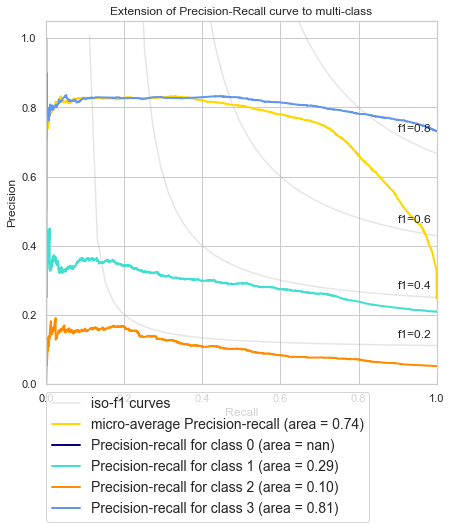

In [88]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(4), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

In [89]:
average_precision

{0: nan,
 1: 0.2879000168135448,
 2: 0.10440892010564322,
 3: 0.8074633313879296,
 'micro': 0.7437031335053762}

In [90]:
from sklearn.inspection import permutation_importance

In [93]:
DTC.feature_importances_

array([0.14707693, 0.22380061, 0.15577001, 0.24539213, 0.22796032])

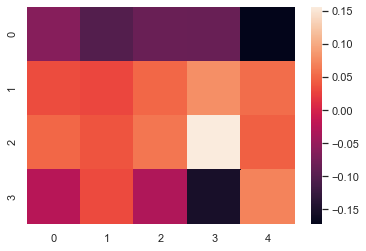

In [97]:
sns.heatmap(LR.coef_)

In [98]:
LR.intercept_

array([-0.84235993,  0.20986745, -0.60331771,  1.23581018])

#### Naive Bayes

In [56]:
GNB_param_grid = {'priors':[None,[0.25,0.25,0.25,0.25],[0.3,0.2,0.3,0.2]]}
GNB, GNB_score, GNB_params, GNB_scores_df, GNB_index, GNB_val_pred, GNB_val_true, GNB_val_pred_proba, GNB_train_scores, GNB_val_scores = \
SamplingGridSearchCV(ROS, GaussianNB(), X_train, y_train, GNB_param_grid, folds=5)
GNB, GNB_score, GNB_index


(GaussianNB(), 0.1024327681839926, 0)

In [57]:
metrics.confusion_matrix(GNB_val_true[GNB_index],GNB_val_pred[GNB_index])

array([[   0,    8,    3,   70],
       [   0,  157,   27, 1793],
       [   0,   53,    7,  428],
       [   2,  233,   34, 6645]])

In [58]:
GNB_scores_df

0                                     1  \
parameters  {'priors': None}  {'priors': [0.25, 0.25, 0.25, 0.25]}   
train               0.101254                             0.0877257   
val                 0.102433                             0.0874849   

                                           2  
parameters  {'priors': [0.3, 0.2, 0.3, 0.2]}  
train                              0.0855352  
val                                0.0848282

In [59]:
metrics.confusion_matrix(GNB_val_true[2],GNB_val_pred[2])

array([[  12,    9,   34,   26],
       [ 294,  197,  611,  875],
       [  90,   52,  186,  160],
       [ 762,  498, 1345, 4309]])

#### XGBoost

In [60]:
XGB_param_grid = {'max_depth':[3,8],'class_weight':[None,'balanced']}
XGB, XGB_score, XGB_params, XGB_scores_df, XGB_index, XGB_val_pred, XGB_val_true, XGB_val_pred_proba, XGB_train_scores, XGB_val_scores = \
SamplingGridSearchCV(ROS, xgb.XGBClassifier(), X_train, y_train, XGB_param_grid, folds=5)
XGB, XGB_score, XGB_index

(XGBClassifier(base_score=0.5, booster=None, class_weight=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints=None, learning_rate=0.300000012,
               max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=0,
               num_parallel_tree=1, objective='multi:softprob', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
               tree_method=None, validate_parameters=False, verbosity=None),
 0.09305065773335033,
 0)

In [ ]:
class model_out()

In [61]:
XGB_scores_df

0  \
parameters  {'class_weight': None, 'max_depth': 3}   
train                                     0.235946   
val                                      0.0930507   

                                                 1  \
parameters  {'class_weight': None, 'max_depth': 8}   
train                                     0.556943   
val                                      0.0581551   

                                                       2  \
parameters  {'class_weight': 'balanced', 'max_depth': 3}   
train                                           0.235946   
val                                            0.0930507   

                                                       3  
parameters  {'class_weight': 'balanced', 'max_depth': 8}  
train                                           0.556943  
val                                            0.0581551

In [62]:
metrics.confusion_matrix(XGB_val_true[XGB_index],XGB_val_pred[XGB_index])

array([[   0,    8,    1,   72],
       [   1,   90,   14, 1872],
       [   0,   34,    4,  450],
       [   1,  112,   11, 6790]])

In [63]:
#Run loop on multiple codes

#get values and create model v model plots


In [64]:
#function to obtain results and plots (based on val data) for selected model with parameters

In [65]:
import seaborn as sns

In [66]:
import matplotlib.pyplot as plt

In [67]:
naive_conf = metrics.confusion_matrix(y_test, dum_dum.predict(X_test),labels=['Athlete','Average','Fitness','Obese'])

In [68]:
naive_conf

array([[   0,    0,    0,   19],
       [   0,    0,    0,  480],
       [   0,    0,    0,  115],
       [   0,    0,    0, 1752]])

## Scratch for personal scoring metrics

In [69]:
def my_scorer2(clf, X, y_true):
    class_labels = clf.classes_
    y_pred_proba = clf.predict_proba(X)
    
    score_points = np.array([[1,0.2,0.8,0],[0.2,1,0.4,0.6],[0.8,0.4,1,.2],[0,.6,.2,1]])
    y_test_bin = LabelBinarizer().fit(class_labels).transform(y_true)
    interstep = np.matmul(y_test_bin,score_points)
    
    fin = interstep*clf.predict_proba(X)
    
    error = fin.sum()/len(fin)
    return error

In [70]:
score_points = np.array([[1,0.2,0.8,0],[0.2,1,0.4,0.6],[0.8,0.4,1,.2],[0,.6,.2,1]])

In [71]:
score_points

array([[1. , 0.2, 0.8, 0. ],
       [0.2, 1. , 0.4, 0.6],
       [0.8, 0.4, 1. , 0.2],
       [0. , 0.6, 0.2, 1. ]])

In [72]:
from sklearn.preprocessing import LabelBinarizer

In [73]:
lb = LabelBinarizer()
lb.fit(['Athlete','Average','Fitness','Obese'])

LabelBinarizer()

In [74]:
y_test_bin = lb.transform(y_test)
y_test_bin

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [75]:
len(y_test_bin)

2366

In [76]:
y_test_bin[0]

array([0, 0, 0, 1])

In [77]:
len(np.matmul(y_test_bin,score_points))

2366

In [78]:
interstep = np.matmul(y_test_bin,score_points)

In [79]:
interstep[0]

array([0. , 0.6, 0.2, 1. ])

In [80]:
DTC_prob[0]

NameError: name 'DTC_prob' is not defined

In [ ]:
fin = interstep*DTC_prob

In [ ]:
len(fin)

In [ ]:
fin_score = fin.sum()/len(fin)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
y_test

In [ ]:
compute_sample_weight(class_weight='balanced',y=y_test)